In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster(memory_limit='16GB')
# client = Client(cluster)
# client

In [10]:
import sys
from pathlib import Path
import pandas as pd
import tarfile
import urllib

def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
metadata = load_metadata()

def extract_eeg():
  eeg_dir = Path("../data/eeg")
  tarball_path = Path("data/eeg.tar.gz")
  if not tarball_path.is_file():
    url = 'https://dl.dropboxusercontent.com/scl/fi/5sina48c4naaxv6uze0fv/eeg.tar.gz?rlkey=r7ec191extynfcm8fy0tsiws5&dl=0'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as eeg_tarball:
      eeg_tarball.extractall()
    
extract_eeg()

metadata

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [11]:
# Add a unique id to each sample
from src.utils.utils import compute_signal_hash

def compute_unique_id(row):
  return str(compute_signal_hash(row))

metadata['unique_id'] = metadata.apply(compute_unique_id, axis=1)

cols = metadata.columns.tolist()
cols = [cols[-1]] + cols[:-1]
metadata = metadata[cols]
metadata


,unique_id,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,db76e9927,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,0e1116d9d,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,8ec6d3c8c,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,662b0bd39,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,ca946aadb,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,368247dd8,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,a7a60ad75,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,97f63909c,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,a5399830b,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [12]:
import dask.dataframe as dd
from src.utils import compute_signal_hash

channel_order = ['Fp1', 'Fp2',
            'F7', 'F3', 'Fz', 'F4', 'F8', 
            'T3', 'C3', 'Cz', 'C4', 'T4', 
            'T5', 'P3', 'Pz', 'P4', 'T6', 
            'O1', 'O2',
          ]

def load_signals(metadata):
  rows = len(metadata)
  eeg_list = []

  for row in range(0,rows):
    sample = metadata.iloc[row]
    f_name = f'data/eeg/{sample.eeg_id}.parquet'
    eeg = pd.read_parquet(f_name)[channel_order]
    eeg_offset = int(sample.eeg_label_offset_seconds)

    eeg['unique_id'] = sample['unique_id']
    eeg = eeg.set_index('unique_id')

    eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]
    eeg_list.append(eeg)

  return dd.concat(eeg_list)

ddf = load_signals(metadata)


In [13]:
# Compute 150 signals to start
df = ddf.compute()
eeg_ids = list(set(df.index))
df

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
unique_id,,,,,,,,,,,,,,,,,,,
db76e9927,-14.780000,-33.049999,-8.910000,-5.600000,-21.650000,1.780000,-26.129999,9.850000,-16.209999,-33.310001,-17.459999,3.22,-5.170000,-14.370000,-13.94,-24.629999,-4.620000,-27.780001,-17.980000
db76e9927,-8.100000,-34.610001,-26.570000,-2.770000,-20.350000,0.660000,-35.130001,13.400000,-16.600000,-36.060001,-17.309999,15.12,-3.140000,-15.580000,-15.91,-25.969999,-1.740000,-28.480000,-20.629999
db76e9927,-3.530000,-34.709999,17.120001,15.570000,-19.110001,-0.770000,-24.709999,30.219999,-8.930000,-32.369999,-23.840000,-2.82,14.670000,-6.310000,-8.61,-20.760000,4.840000,-18.500000,-10.460000
db76e9927,-3.370000,-29.330000,13.520000,11.710000,-20.629999,-4.140000,10.330000,24.660000,-10.640000,-33.750000,-32.400002,-4.81,14.880000,-5.840000,-11.61,-24.910000,-2.940000,-18.680000,-13.950000
db76e9927,-3.830000,-27.459999,14.320000,-2.420000,-20.000000,-3.300000,-9.990000,19.590000,-12.090000,-35.860001,-27.650000,7.83,4.900000,-11.270000,-16.00,-27.860001,-4.780000,-25.540001,-20.190001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bbdf2f28e,-39.990002,-11.380000,14.590000,-20.500000,-15.240000,-23.340000,-57.529999,-12.530000,7.420000,-20.930000,-16.010000,1.68,-3.070000,-1.150000,2.43,-0.170000,-23.500000,-6.850000,3.350000
bbdf2f28e,-74.470001,-50.410000,-10.230000,-46.110001,-35.630001,-53.380001,-85.099998,-32.070000,-14.630000,-38.250000,-40.669998,-25.49,-22.780001,-22.990000,-15.43,-26.559999,-49.869999,-26.160000,-22.389999
bbdf2f28e,-66.209999,-31.180000,-4.690000,-39.560001,-26.389999,-49.680000,-75.089996,-27.030001,-7.510000,-28.959999,-32.930000,-10.00,-10.790000,-11.880000,-5.56,-20.100000,-42.110001,-11.150000,-14.310000


In [14]:
# # Apply filtering
# from src.preprocessing.preprocessing import bp_filter, notch_filter
# from scipy.signal import iirnotch, filtfilt, butter

# def apply_notch_filter(df, fs, f0):
#   filtered = df.copy()
#   b,a = iirnotch(f0, 30, fs)
#   for column in filtered.columns:
#     filtered[column] = filtfilt(b, a, df[column])
#   return filtered

# def apply_bp_filter(df, fs, lowcut, highcut):
#   filtered = df.copy()
#   nyq = 0.5*fs
#   low = lowcut / nyq
#   high = highcut/nyq
#   b,a = butter(5, [low,high], btype='band')
#   for channel in filtered.columns:
#     filtered[channel] = filtfilt(b,a, df[channel])
#   return filtered


# filtered_data = apply_notch_filter(df, 200, 60)
# filtered_data = apply_bp_filter(filtered_data, 200, 0.5, 50)

In [15]:
# df
# from src.preprocessing.preprocessing import wavelet_transform
# from src.visualize import plot_signal
# import numpy as np

# sig = df.loc['db76e9927']
# plot_signal(sig, 5, ['F3',	'Fz',	'F4',	'F8',	'T3'])


In [16]:
from src.preprocessing.preprocessing import wavelet_transform
sig_denoised = wavelet_transform(df, 2, basis='bior3.3')

/opt/anaconda3/envs/340-project/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting top 3 channels based on max variance for all samples
- 1000 samples computation duration = approx. 15 minutes

In [17]:
from src.feature_extraction import calculate_all_samples

top_channels_df = calculate_all_samples(sig_denoised, eeg_ids, len(eeg_ids))
top_channels_df

,0,1,2
1c28229c4,Fp1,Fp2,F7
849d78c59,Pz,O2,C3
f4bb57d19,F7,O2,Fp2
b9a0de027,O1,F8,O2
d5d2a9f36,Fp1,Fz,Cz
...,...,...,...
d6b0fcfaf,Pz,O2,O1
03d5ba3fd,O2,C3,Fp2
c66d6df37,Fp2,F8,F4
2667acce0,Cz,Pz,Fp1


Extracting Statistical Features from every sample with extraction function
- 1000 samples computation duration = approx. 20 minutes

In [18]:
from src.feature_extraction import extract_features_all_samples

features_df = extract_features_all_samples(df, top_channels_df)
features_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow
1c28229c4,20.03116,-12.709617,78.99,-76.693334,402.212321,-13.936667,0.814439,6.045306,5.412814,1018229.5,62741277580.531258
849d78c59,914.575928,13.023507,2750.203369,-4657.32666,868589.166667,16.736667,-1.785036,10.034237,5.914429,8847282580138.666016,86921246524998.328125
f4bb57d19,61.070085,-23.130338,209.493332,-262.889994,3774.40861,-21.738333,-0.168481,3.316686,5.087195,48428121.333333,431711503375.28363
b9a0de027,23.179344,-13.683254,65.766666,-78.363332,537.532918,-14.716667,0.212179,2.821812,5.0155,817504.229167,77510417943.443298
d5d2a9f36,149.328028,19.359751,440.939992,-309.523336,22310.268229,25.433334,0.002568,1.927601,4.581203,962615701.333333,2298064360166.436035
...,...,...,...,...,...,...,...,...,...,...,...
d6b0fcfaf,15.490821,-17.664679,97.736666,-70.946664,240.205785,-19.708333,1.871983,9.448098,5.247585,551146.770833,55801742135.863647
03d5ba3fd,29.935548,-7.703929,105.446668,-124.5,932.423635,-6.91,-0.059667,4.141358,5.132572,4768280.229167,112196266628.333939
c66d6df37,59.024799,-1.596562,188.423335,-246.286667,3486.606038,4.703334,-0.706679,4.083719,5.1268,49422832.0,356658910286.88092
2667acce0,73.58403,-19.410183,313.296672,-261.736674,5481.362305,-28.483334,0.483936,3.974424,5.051383,116590652.0,606774782273.642456


Setting up Feature Data and Target Data for correct format to split data and Input to Microsoft's Light Gradient Boosting Machine (LGBM)

In [19]:
# Setup feature table
# input_df = pd.merge(features_df, metadata[['unique_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']], left_index=True, right_on='unique_id')
input_df = pd.merge(features_df, metadata[['unique_id', 'expert_consensus']], left_index=True, right_on='unique_id')
input_df = input_df.set_index('unique_id')
input_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow,expert_consensus
unique_id,,,,,,,,,,,,
1c28229c4,20.03116,-12.709617,78.99,-76.693334,402.212321,-13.936667,0.814439,6.045306,5.412814,1018229.5,62741277580.531258,GRDA
849d78c59,914.575928,13.023507,2750.203369,-4657.32666,868589.166667,16.736667,-1.785036,10.034237,5.914429,8847282580138.666016,86921246524998.328125,Seizure
f4bb57d19,61.070085,-23.130338,209.493332,-262.889994,3774.40861,-21.738333,-0.168481,3.316686,5.087195,48428121.333333,431711503375.28363,Seizure
b9a0de027,23.179344,-13.683254,65.766666,-78.363332,537.532918,-14.716667,0.212179,2.821812,5.0155,817504.229167,77510417943.443298,GPD
d5d2a9f36,149.328028,19.359751,440.939992,-309.523336,22310.268229,25.433334,0.002568,1.927601,4.581203,962615701.333333,2298064360166.436035,LRDA
...,...,...,...,...,...,...,...,...,...,...,...,...
d6b0fcfaf,15.490821,-17.664679,97.736666,-70.946664,240.205785,-19.708333,1.871983,9.448098,5.247585,551146.770833,55801742135.863647,GPD
03d5ba3fd,29.935548,-7.703929,105.446668,-124.5,932.423635,-6.91,-0.059667,4.141358,5.132572,4768280.229167,112196266628.333939,LRDA
c66d6df37,59.024799,-1.596562,188.423335,-246.286667,3486.606038,4.703334,-0.706679,4.083719,5.1268,49422832.0,356658910286.88092,LPD


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


x = input_df.iloc[:, :11].astype(float)
y = input_df[['expert_consensus']].to_numpy().flatten()

categories = ['Seizure', 'LPD', 'GPD', 'LRDA', 'GRDA', 'Other']

le = LabelEncoder()
le.fit(categories)
y = le.transform(y)


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=68)

In [30]:
X_test

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow
unique_id,,,,,,,,,,,
60269dbe0,69.498013,-14.000540,269.060003,-231.826673,5387.648682,-18.656668,0.892926,6.305258,5.347369,1.844210e+08,5.605680e+11
7824b136a,41.136082,-10.546766,144.803332,-177.906667,1694.043620,-8.686666,-0.303199,4.716401,5.265601,1.329711e+07,1.914752e+11
7c4545352,54.497690,-15.362103,118.763334,-294.920003,2970.043213,-4.960000,-1.110978,4.949692,5.143020,4.365988e+07,3.432375e+11
7ac9b6724,48.386712,-0.381620,141.416667,-176.023336,2341.346924,2.853333,-0.290903,2.702723,4.950537,1.481686e+07,2.527246e+11
704f22883,45.964165,2.836210,182.939997,-172.040001,2134.387573,0.926667,0.116366,3.021317,5.039783,1.412912e+07,2.452223e+11
...,...,...,...,...,...,...,...,...,...,...,...
93fb959ff,84.597150,-11.569814,244.550003,-171.223338,7318.266113,-27.846666,0.580195,2.470646,4.744481,1.431328e+08,7.503633e+11
da23c47f5,162.052663,-32.306368,523.573324,-798.713333,31453.386475,1.225000,-1.432968,8.606414,5.965096,1.299130e+10,3.260993e+12
db76e9927,22.934624,-9.610889,60.386666,-79.040001,528.377004,-7.756667,-0.148120,2.763834,4.980392,7.513298e+05,8.203539e+10


In [31]:
y_test

array([5, 1, 0, 0, 4, 2, 5, 4, 0, 4, 0, 1, 0, 4, 4, 2, 1, 1, 5, 0, 3, 0,
       3, 4, 0, 0, 3, 0, 5, 5, 2, 5, 3, 4, 5, 3, 2, 0, 0, 0, 5, 1, 5, 1,
       5, 4, 0, 5, 5, 5, 2, 4, 4, 5, 4, 3, 1, 5, 3, 0, 4, 5, 5, 4, 3, 5,
       1, 0, 0, 3, 4, 1, 3, 0, 1, 3, 5, 0, 4, 4, 0, 0, 3, 1, 5, 4, 0, 0,
       1, 4, 4, 4, 1, 5, 3, 1, 2, 4, 2, 0, 2, 3, 3, 1, 1, 0, 1, 0, 4, 2,
       2, 2, 4, 1, 0, 1, 4, 3, 0, 3, 4, 3, 2, 1, 5, 5, 1, 3, 3, 3, 0, 4,
       5, 3, 2, 1, 5, 3, 4, 1, 1, 3, 5, 2, 1, 1, 2, 5, 2, 1, 0, 0, 5, 0,
       4, 4, 5, 4, 5, 2, 0, 4, 2, 4, 1, 5, 4, 2, 2, 4, 0, 4, 1, 4, 0, 4,
       4, 1, 2, 1, 5, 3, 5, 3, 1, 0, 1, 5, 2, 5, 3, 2, 0, 5, 2, 0, 0, 1,
       4, 3])

Inputting Parameters for LGBM Model
- parameters were obtained by observing similiar implementation in same competition project using LGBM library. (see report doc --> citations/acknowledgements for more details) 
- Slight adjustments to parameters applied to fit our implementation

In [21]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
params = {
    'objective': 'multiclass',
    'num_class': 6,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'num_leaves': 121,
    'learning_rate': 0.018623105710769177,
    'feature_fraction': 1.0,
    'bagging_fraction': 0.756777580360579,
    'max_depth': 8,
    'verbose': 0
}

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 11
[LightGBM] [Info] Start training from score -1.809414
[LightGBM] [Info] Start training from score -1.794263
[LightGBM] [Info] Start training from score -1.975082
[LightGBM] [Info] Start training from score -1.840425
[LightGBM] [Info] Start training from score -1.809414
[LightGBM] [Info] Start training from score -1.566618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

LGBMClassifier()

Splitting Data 80/20 and adjusting params to obtain training and testing sets

Training our LGBM model on the training data and evaluating it on the test data - Probabilities for each target label are obtained and Displayed

Generating Confusion Matrix with predicted labels and true labels

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.295

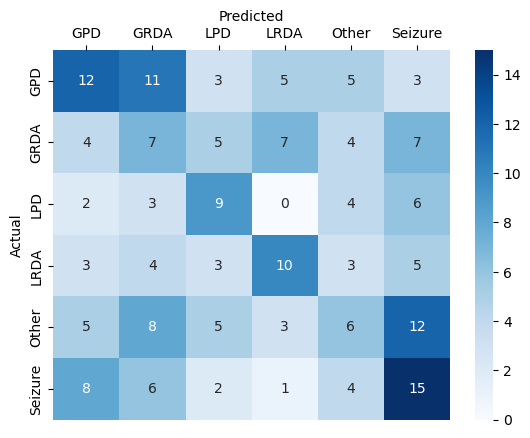

In [23]:
# Generate confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = lgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm)

cm_df.columns = le.inverse_transform([0,1,2,3,4,5]).tolist()
cm_df.index = le.inverse_transform([0,1,2,3,4,5]).tolist()

hm = sns.heatmap(cm_df, annot=True, cmap='Blues')
hm.set_xlabel('Predicted')
hm.set_ylabel('Actual')

hm.xaxis.set_label_position('top')
hm.xaxis.tick_top()

Generating result metrics to evaluate our multiclassification model

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.295
Precision: 0.2944325037707391
Recall: 0.295
F1 Score: 0.29120283608116004


In [25]:
y_pred_proba = lgb_model.predict_proba(X_test)

# Predicted probabilities to DataFrame
pred_df = pd.DataFrame(y_pred_proba, columns=['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
pred_df['eeg_id'] = X_test.index
pred_df = pred_df[['eeg_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
pred_df

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,60269dbe0,0.941701,0.034392,0.004892,0.011891,0.003260,0.003863
1,7824b136a,0.123795,0.188758,0.052658,0.483668,0.043957,0.107165
2,7c4545352,0.026231,0.239644,0.282647,0.340496,0.027107,0.083875
3,7ac9b6724,0.387767,0.149849,0.038617,0.005181,0.411267,0.007318
4,704f22883,0.128075,0.125884,0.000972,0.709873,0.018696,0.016500
...,...,...,...,...,...,...,...
195,93fb959ff,0.994407,0.000290,0.001876,0.000427,0.002645,0.000355
196,da23c47f5,0.176211,0.036254,0.117996,0.012621,0.064302,0.592616
197,db76e9927,0.417268,0.551071,0.015794,0.010502,0.003953,0.001412
198,8f3e1c4be,0.005592,0.040283,0.170465,0.001652,0.115093,0.666916


Preprocessing Data: Applying Wavelet Transform, Notch filter, Standardization to our data
- Model was trained without preprocessing due to higher scores without

In [26]:
# File created to test the correctness of extracted values using MATLAB
# Save Fp1 channel data into a MATLAB file
# import scipy.io
# scipy.io.savemat('Fp1_data.mat', {'Fp1_data': sig1['Fp1']})

In [27]:
from joblib import dump
model = ... # your trained model
dump(lgb_model, 'model.joblib')


['model.joblib']

In [28]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(lgb_model, file)

In [48]:
X_test

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow
unique_id,,,,,,,,,,,
60269dbe0,69.498013,-14.000540,269.060003,-231.826673,5387.648682,-18.656668,0.892926,6.305258,5.347369,1.844210e+08,5.605680e+11
7824b136a,41.136082,-10.546766,144.803332,-177.906667,1694.043620,-8.686666,-0.303199,4.716401,5.265601,1.329711e+07,1.914752e+11
7c4545352,54.497690,-15.362103,118.763334,-294.920003,2970.043213,-4.960000,-1.110978,4.949692,5.143020,4.365988e+07,3.432375e+11
7ac9b6724,48.386712,-0.381620,141.416667,-176.023336,2341.346924,2.853333,-0.290903,2.702723,4.950537,1.481686e+07,2.527246e+11
704f22883,45.964165,2.836210,182.939997,-172.040001,2134.387573,0.926667,0.116366,3.021317,5.039783,1.412912e+07,2.452223e+11
...,...,...,...,...,...,...,...,...,...,...,...
93fb959ff,84.597150,-11.569814,244.550003,-171.223338,7318.266113,-27.846666,0.580195,2.470646,4.744481,1.431328e+08,7.503633e+11
da23c47f5,162.052663,-32.306368,523.573324,-798.713333,31453.386475,1.225000,-1.432968,8.606414,5.965096,1.299130e+10,3.260993e+12
db76e9927,22.934624,-9.610889,60.386666,-79.040001,528.377004,-7.756667,-0.148120,2.763834,4.980392,7.513298e+05,8.203539e+10


In [59]:
sample_input = X_test.iloc[0:1]

In [60]:
sample_input

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow
unique_id,,,,,,,,,,,
60269dbe0,69.498013,-14.00054,269.060003,-231.826673,5387.648682,-18.656668,0.892926,6.305258,5.347369,1.844210e+08,5.605680e+11


In [61]:
sample_input.to_csv('sample.csv')
